This essentially enables you to download the dataset from MedMNIST 

In [ ]:
import medmnist
from medmnist import DermaMNIST #REPLACE
import numpy as np

# Choose the image size (28 for classic, or 64/128/224 for MedMNIST+)
IMG_SIZE = 28  

# Download DermMNIST (train/val/test) automatically
train_dataset = DermaMNIST(split="train", download=True, size=IMG_SIZE) #REPLACE
val_dataset   = DermaMNIST(split="val", download=True, size=IMG_SIZE) #REPLACE
test_dataset  = DermaMNIST(split="test", download=True, size=IMG_SIZE) #REPLACE

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

# Each dataset item is a tuple (PIL.Image, label)
img, label = train_dataset[0]

# Convert PIL image → NumPy array
img_array = np.array(img)

print("Sample image shape:", img_array.shape, "Label:", label)


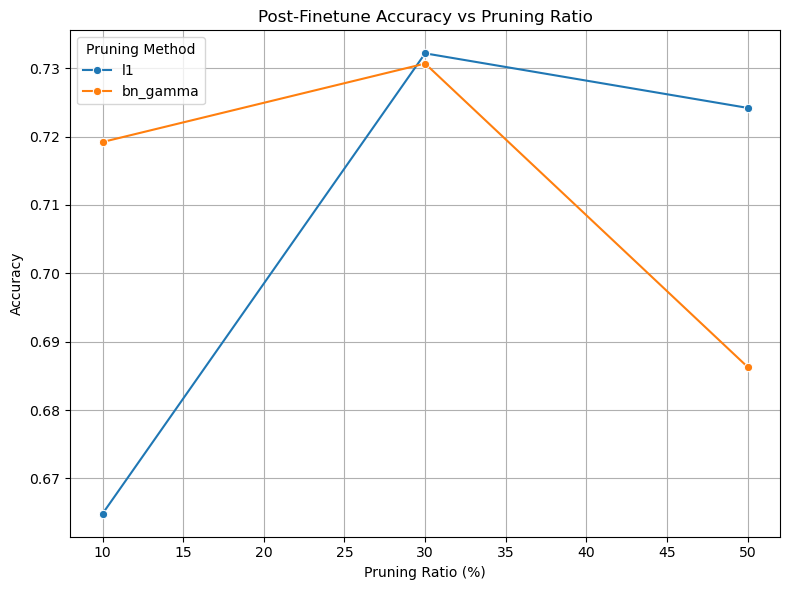

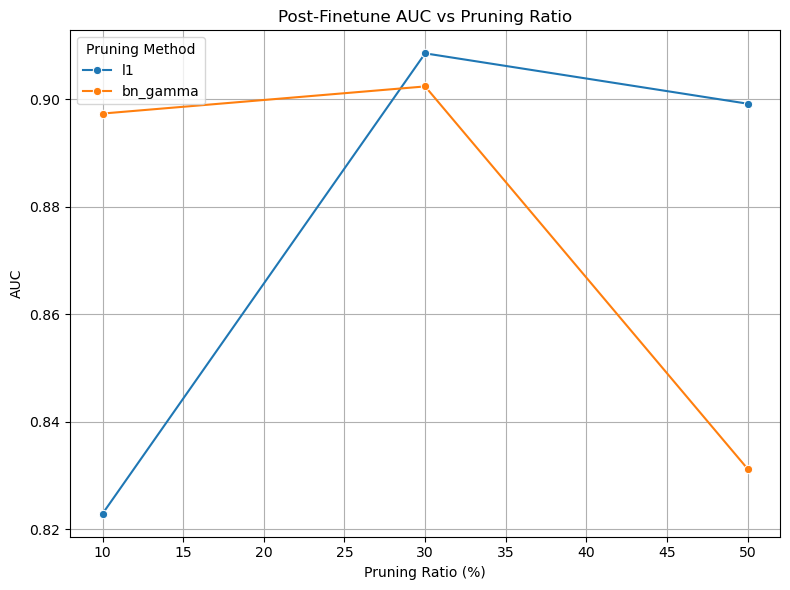

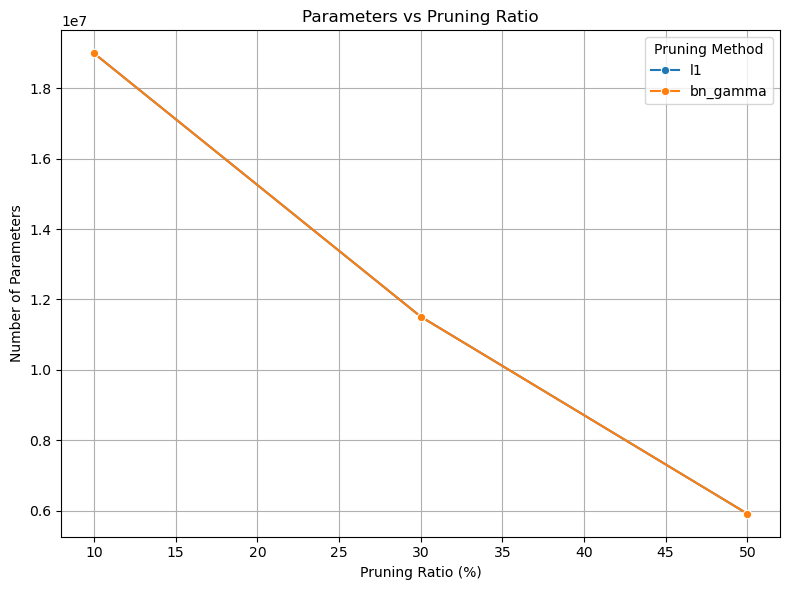

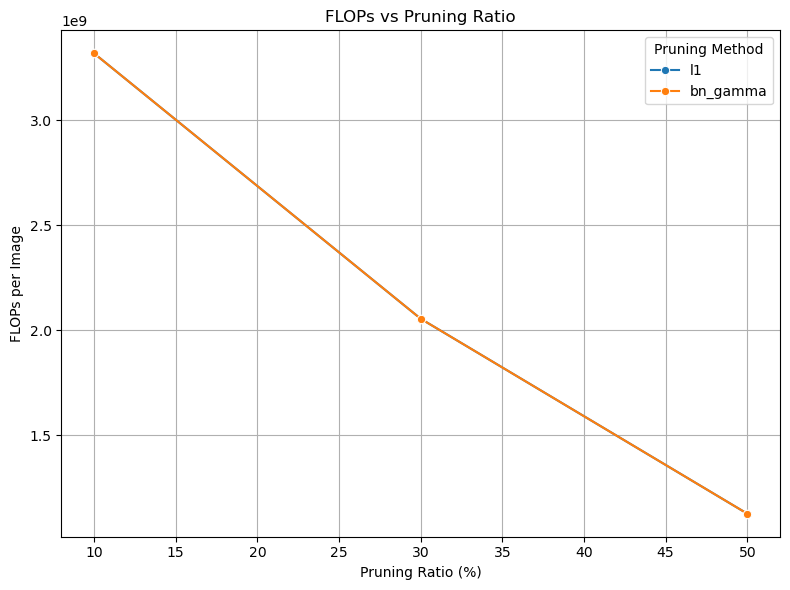

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Load CSV
# ---------------------------
csv_path = "/Users/arihangupta/Downloads/dermamnist_surgery_pruning_metrics.csv"  # update with your path
df = pd.read_csv(csv_path)

# ---------------------------
# Preprocess
# ---------------------------
# Convert Ratio to percentage for plotting
df['RatioPercent'] = df['Ratio'] * 100

# ---------------------------
# Plot Accuracy vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")], 
    x='RatioPercent', y='Acc', hue='Variant', marker='o'
)
plt.title("Post-Finetune Accuracy vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()

# ---------------------------
# Plot AUC vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")], 
    x='RatioPercent', y='AUC', hue='Variant', marker='o'
)
plt.title("Post-Finetune AUC vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("AUC")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Params vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")],
    x='RatioPercent', y='Params', hue='Variant', marker='o'
)
plt.title("Parameters vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("Number of Parameters")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()

# ---------------------------
# Plot FLOPs vs Pruning Ratio
# ---------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df[df['Stage'].str.contains("after_finetune")],
    x='RatioPercent', y='FLOPs_per_image', hue='Variant', marker='o'
)
plt.title("FLOPs vs Pruning Ratio")
plt.xlabel("Pruning Ratio (%)")
plt.ylabel("FLOPs per Image")
plt.grid(True)
plt.legend(title="Pruning Method")
plt.tight_layout()
plt.show()


Block-by-Block pruning

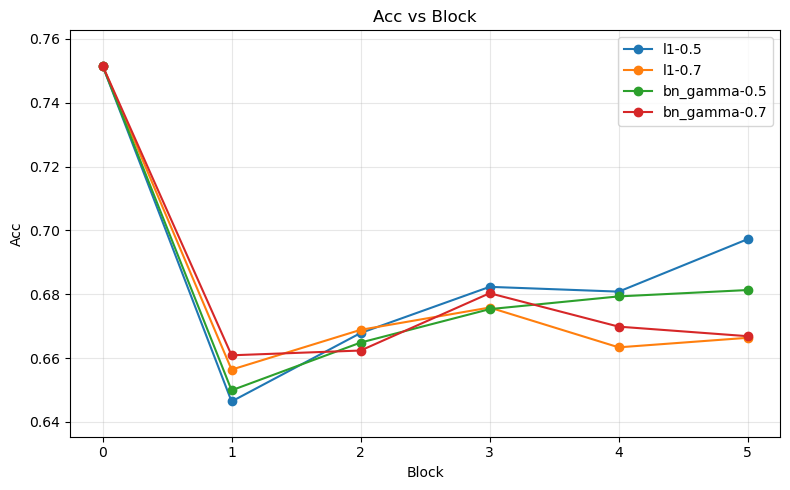

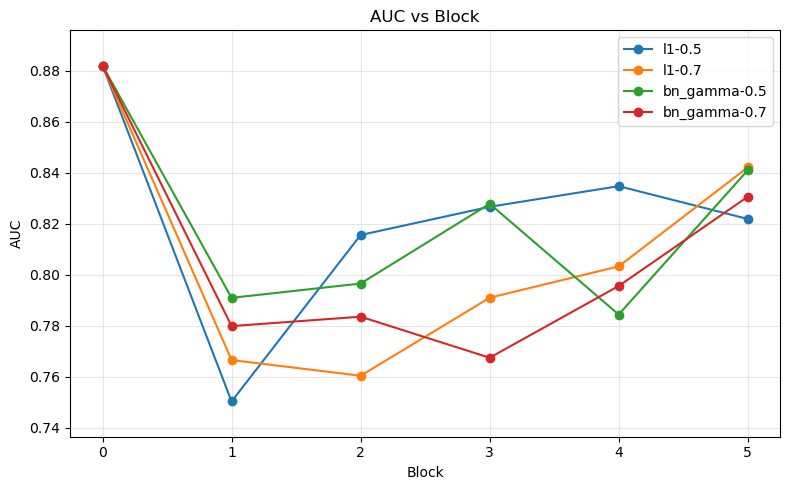

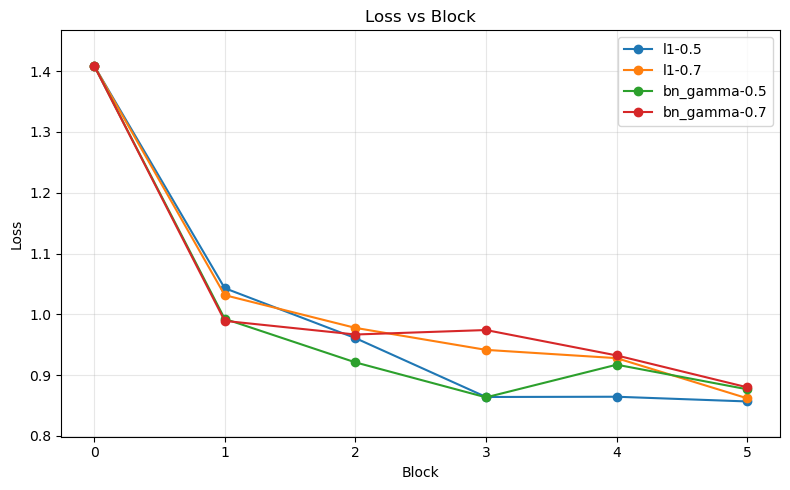

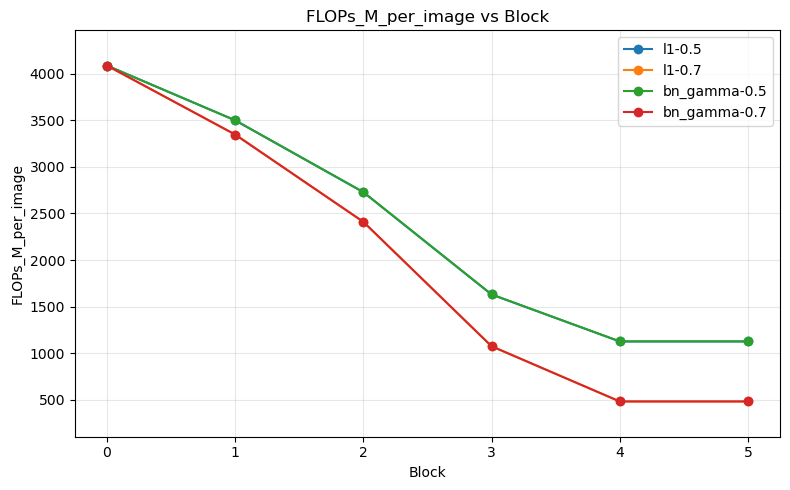

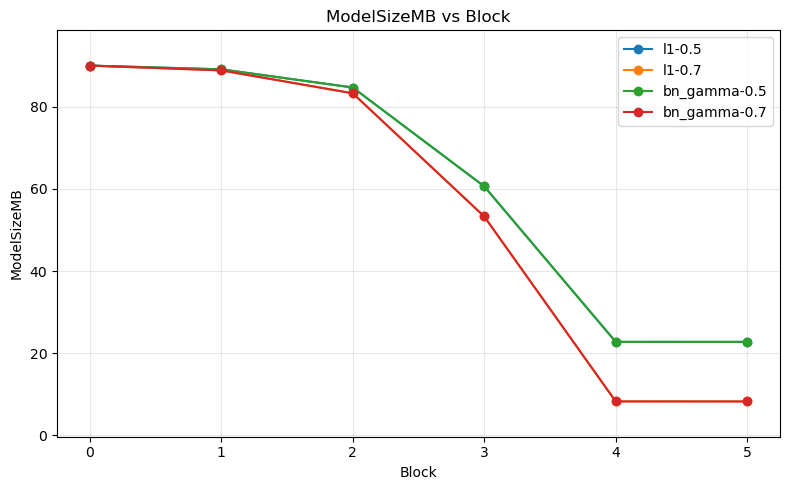

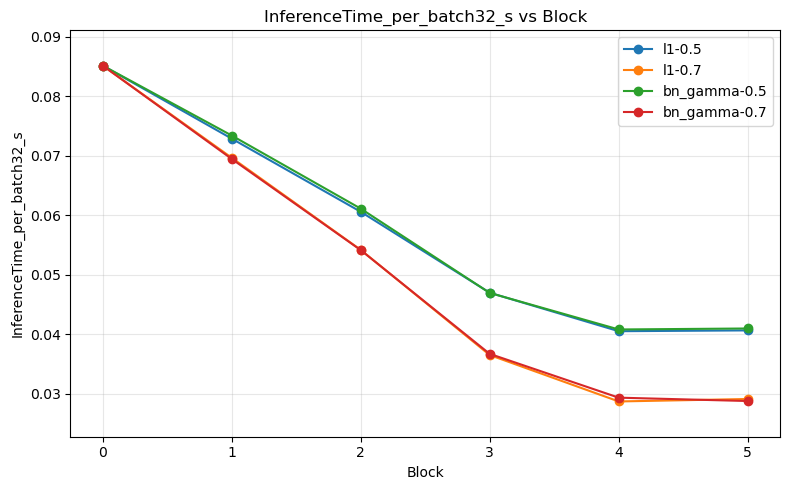

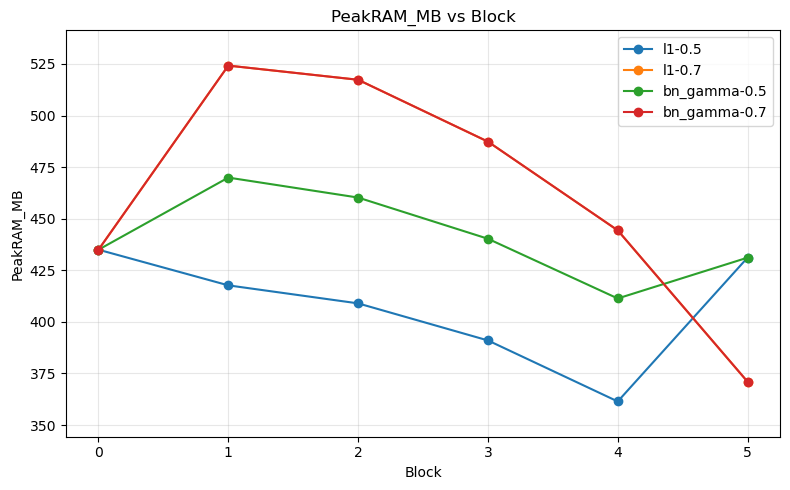

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/Users/arihangupta/Downloads/dermamnist_pgto_pruning_metrics.csv")

# Map Stage -> Block
def stage_to_block(stage):
    if stage == "baseline":
        return 0
    elif "layer1" in stage:
        return 1
    elif "layer2" in stage:
        return 2
    elif "layer3" in stage:
        return 3
    elif "layer4" in stage:
        return 4
    elif "finetune" in stage:
        return 5
    return None

df["Block"] = df["Stage"].apply(stage_to_block)

# Variants of interest
variants = [
    ("l1", 0.5),
    ("l1", 0.7),
    ("bn_gamma", 0.5),
    ("bn_gamma", 0.7),
]

# Metrics
metrics = ["Acc", "AUC", "Loss", "FLOPs_M_per_image", 
           "ModelSizeMB", "InferenceTime_per_batch32_s", "PeakRAM_MB"]

for metric in metrics:
    plt.figure(figsize=(8,5))

    for method, ratio in variants:
        # Get variant rows
        subset = df[(df["Variant"] == method) & (df["Ratio"] == ratio)]

        # Append baseline (Block 0) explicitly
        baseline = df[df["Stage"] == "baseline"].copy()
        baseline["Variant"] = method
        baseline["Ratio"] = ratio
        subset = pd.concat([baseline, subset]).sort_values("Block")

        # Plot
        plt.plot(
            subset["Block"], subset[metric],
            marker="o", label=f"{method}-{ratio}"
        )

    plt.xlabel("Block")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Block")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Ensure x-axis is discrete integers only
    plt.xticks(sorted(df["Block"].dropna().unique()))

    # Add padding to y-limits so curves don’t get cut off
    ymin, ymax = plt.ylim()
    plt.ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))

    plt.tight_layout()
    plt.show()


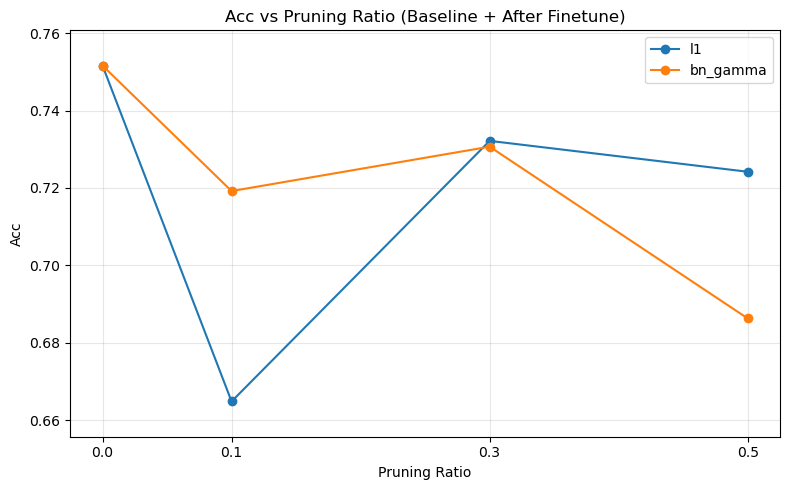

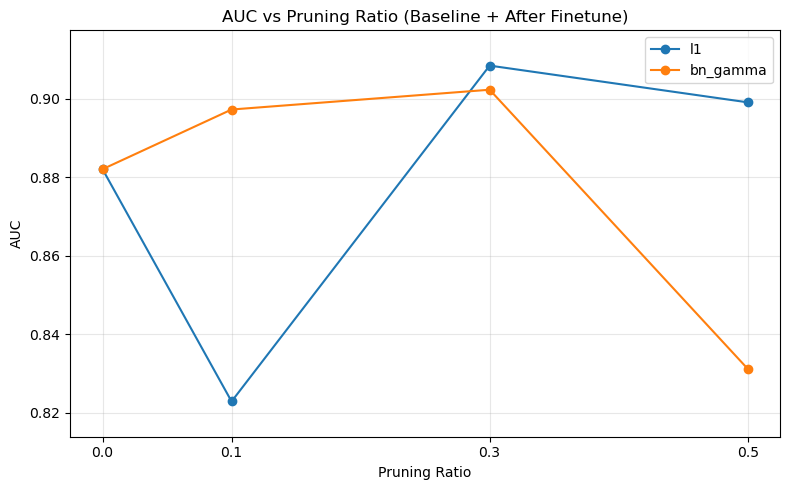

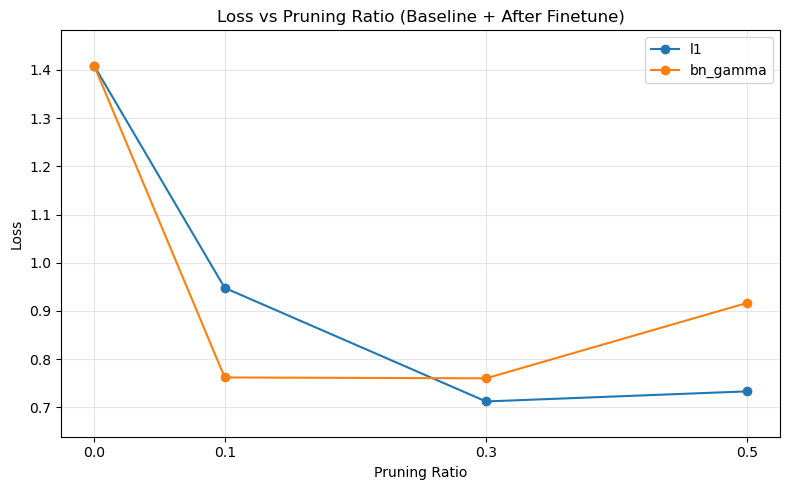

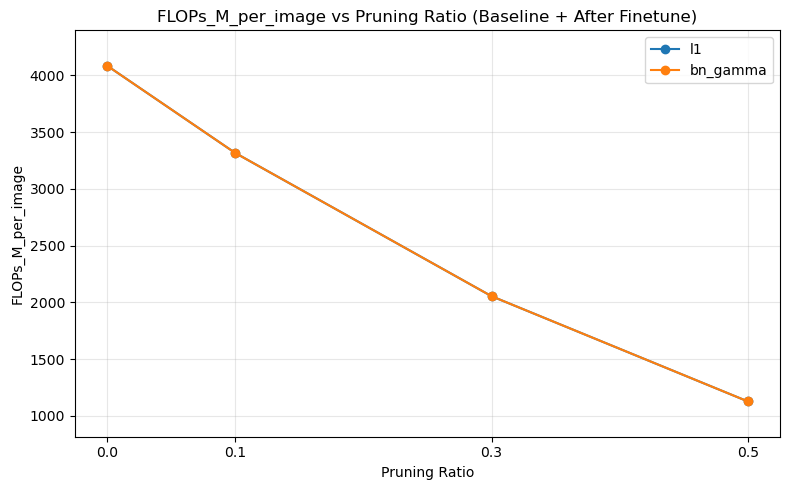

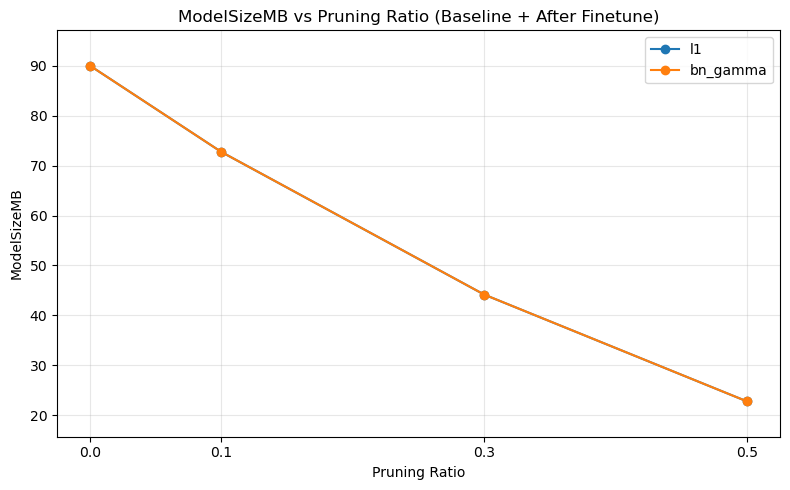

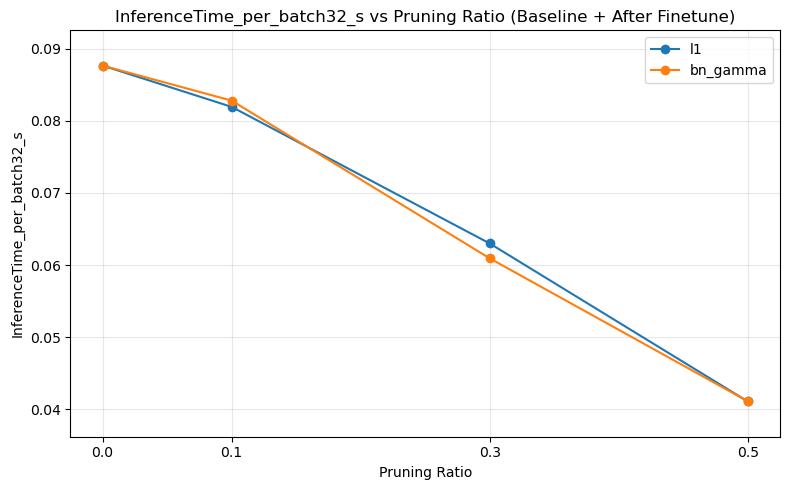

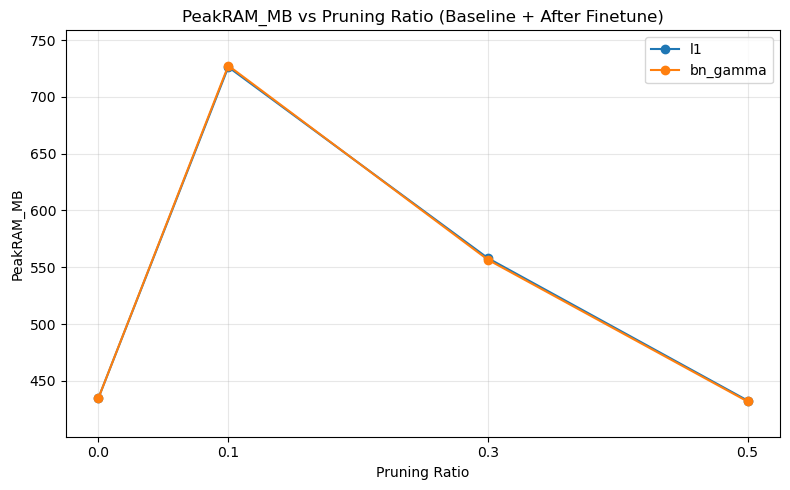

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/Users/arihangupta/Downloads/dermamnist_surgery_pruning_metrics.csv")

# Keep only baseline + after_finetune rows
df_baseline = df[df["Stage"] == "baseline"]
df_after = df[df["Stage"] == "after_finetune"]

# Metrics to plot
metrics = ["Acc", "AUC", "Loss", "FLOPs_M_per_image", 
           "ModelSizeMB", "InferenceTime_per_batch32_s", "PeakRAM_MB"]

# Variants of interest
variants = df_after["Variant"].unique()

for metric in metrics:
    plt.figure(figsize=(8,5))

    for variant in variants:
        # Get baseline row
        baseline_row = df_baseline.copy()
        baseline_row["Variant"] = variant  # assign to variant line

        # Get after_finetune rows for this variant
        after_rows = df_after[df_after["Variant"] == variant]

        # Combine baseline + after
        plot_data = pd.concat([baseline_row, after_rows]).sort_values("Ratio")

        plt.plot(
            plot_data["Ratio"], plot_data[metric],
            marker="o", label=variant
        )

    plt.xlabel("Pruning Ratio")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Pruning Ratio (Baseline + After Finetune)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # X-axis ticks = all ratios including 0 for baseline
    plt.xticks(sorted(plot_data["Ratio"].unique()))

    # Add y-axis padding
    ymin, ymax = plt.ylim()
    plt.ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))

    plt.tight_layout()
    plt.show()


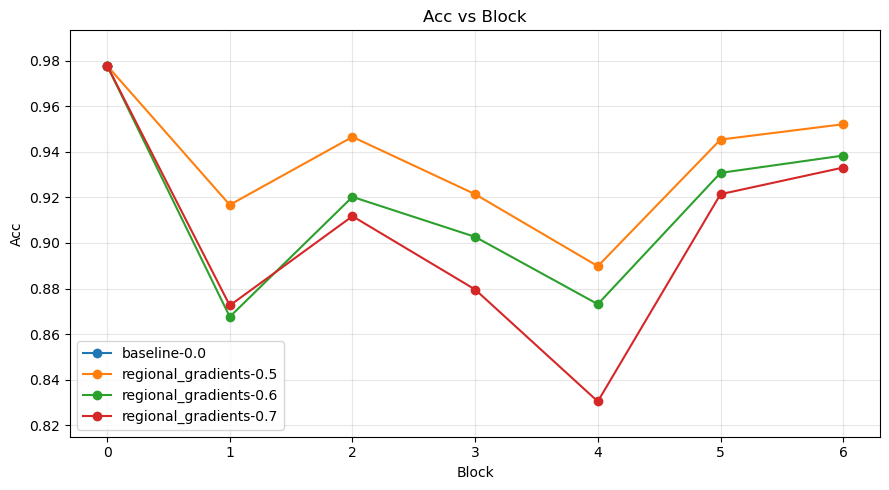

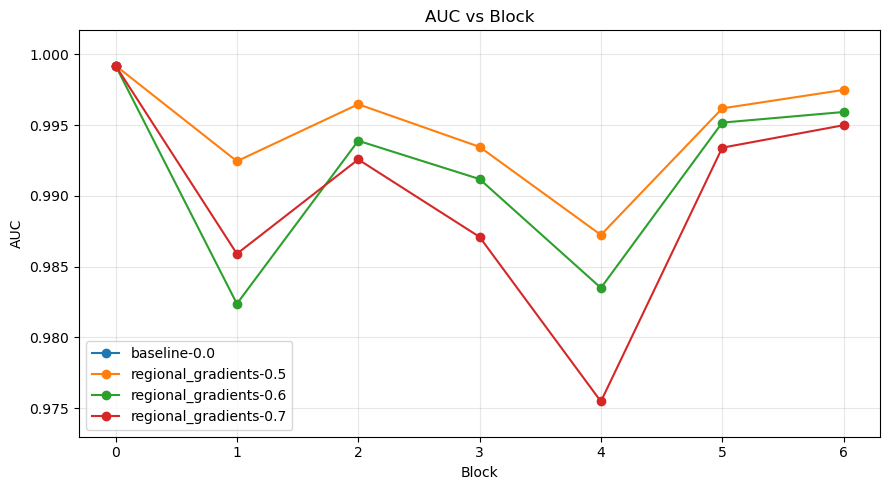

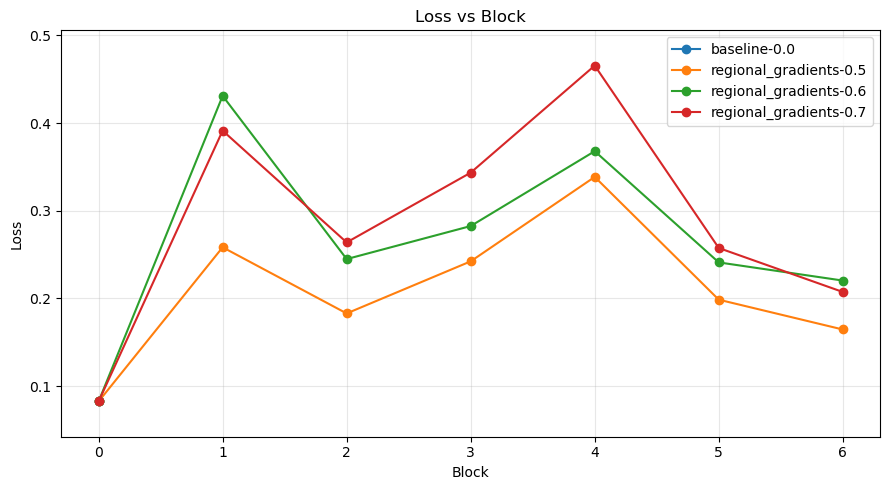

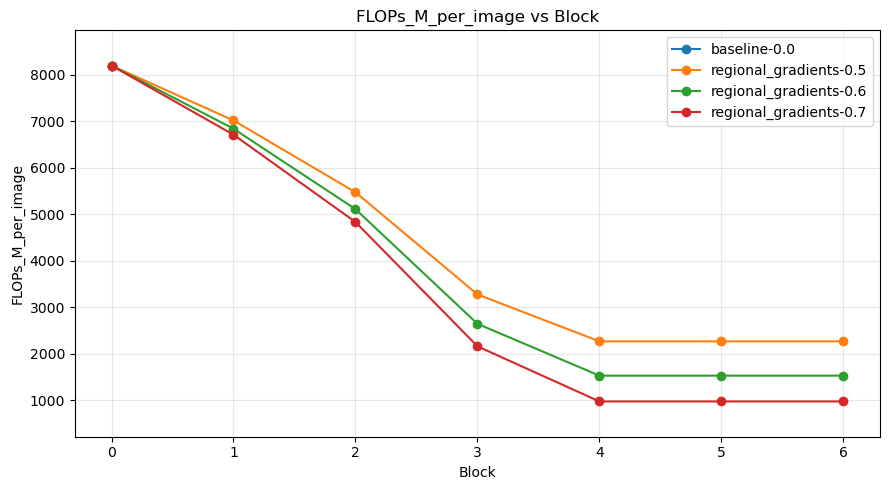

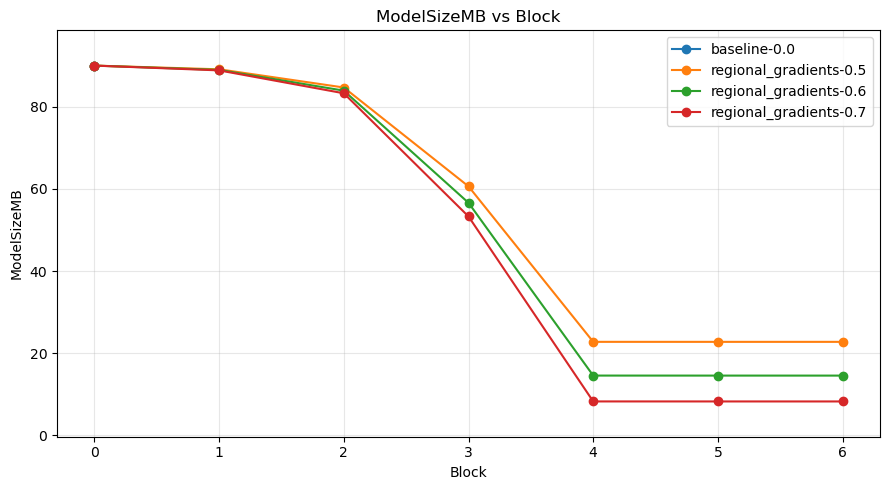

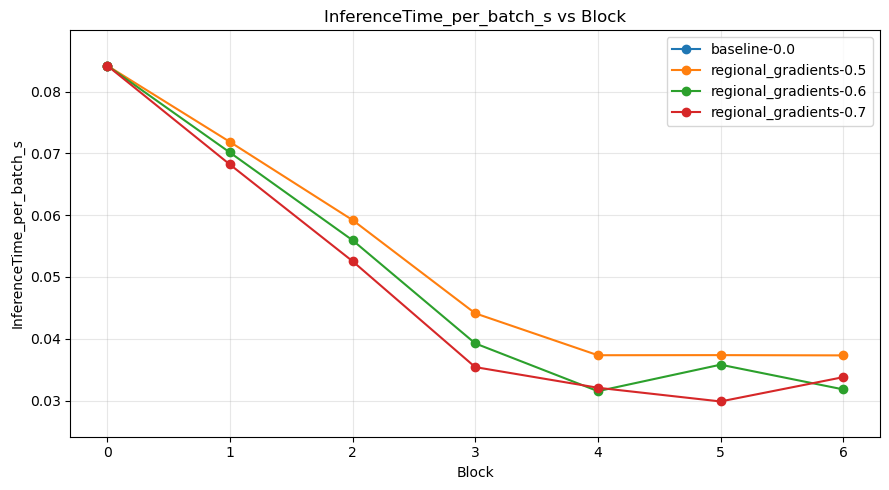

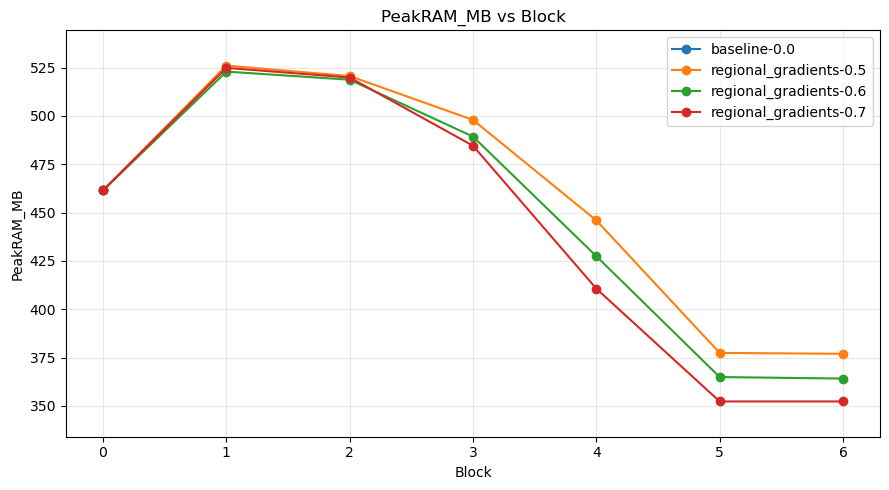

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("/Users/arihangupta/Downloads/bloodmnist_pgto_pruning_metrics_progressive_fixed_with_energy.csv")

# Keep only desired stages
stages_keep = ["postcalib", "after_kd", "after_global_finetune", "baseline"]
df = df[df["Stage"].apply(lambda s: any(k in s for k in stages_keep))].copy()

# Map Stage -> Block index
def stage_to_block(stage: str):
    if stage == "baseline":
        return 0
    elif "layer1" in stage and "postcalib" in stage:
        return 1
    elif "layer2" in stage and "postcalib" in stage:
        return 2
    elif "layer3" in stage and "postcalib" in stage:
        return 3
    elif "layer4" in stage and "postcalib" in stage:
        return 4
    elif stage == "after_kd":
        return 5
    elif stage == "after_global_finetune":
        return 6
    return None

df["Block"] = df["Stage"].apply(stage_to_block)

# Use all unique (Variant, Ratio) pairs
variants = df[["Variant", "Ratio"]].drop_duplicates().values.tolist()

# Metrics to plot
metrics = [
    "Acc", "AUC", "Loss",
    "FLOPs_M_per_image", "ModelSizeMB",
    "InferenceTime_per_batch_s", "PeakRAM_MB"
]

for metric in metrics:
    plt.figure(figsize=(9,5))

    for method, ratio in variants:
        # Get subset
        subset = df[(df["Variant"] == method) & (df["Ratio"] == ratio)].copy()

        # Add baseline explicitly for this variant/ratio
        baseline = df[df["Stage"] == "baseline"].copy()
        baseline["Variant"] = method
        baseline["Ratio"] = ratio
        subset = pd.concat([baseline, subset])

        # Order by Block
        subset = subset.sort_values("Block")

        # Plot
        plt.plot(
            subset["Block"], subset[metric],
            marker="o", label=f"{method}-{ratio}"
        )

    plt.xlabel("Block")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Block")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # X-axis ticks
    plt.xticks(sorted(df["Block"].dropna().unique()))

    # Add y padding
    ymin, ymax = plt.ylim()
    plt.ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))

    plt.tight_layout()
    plt.show()


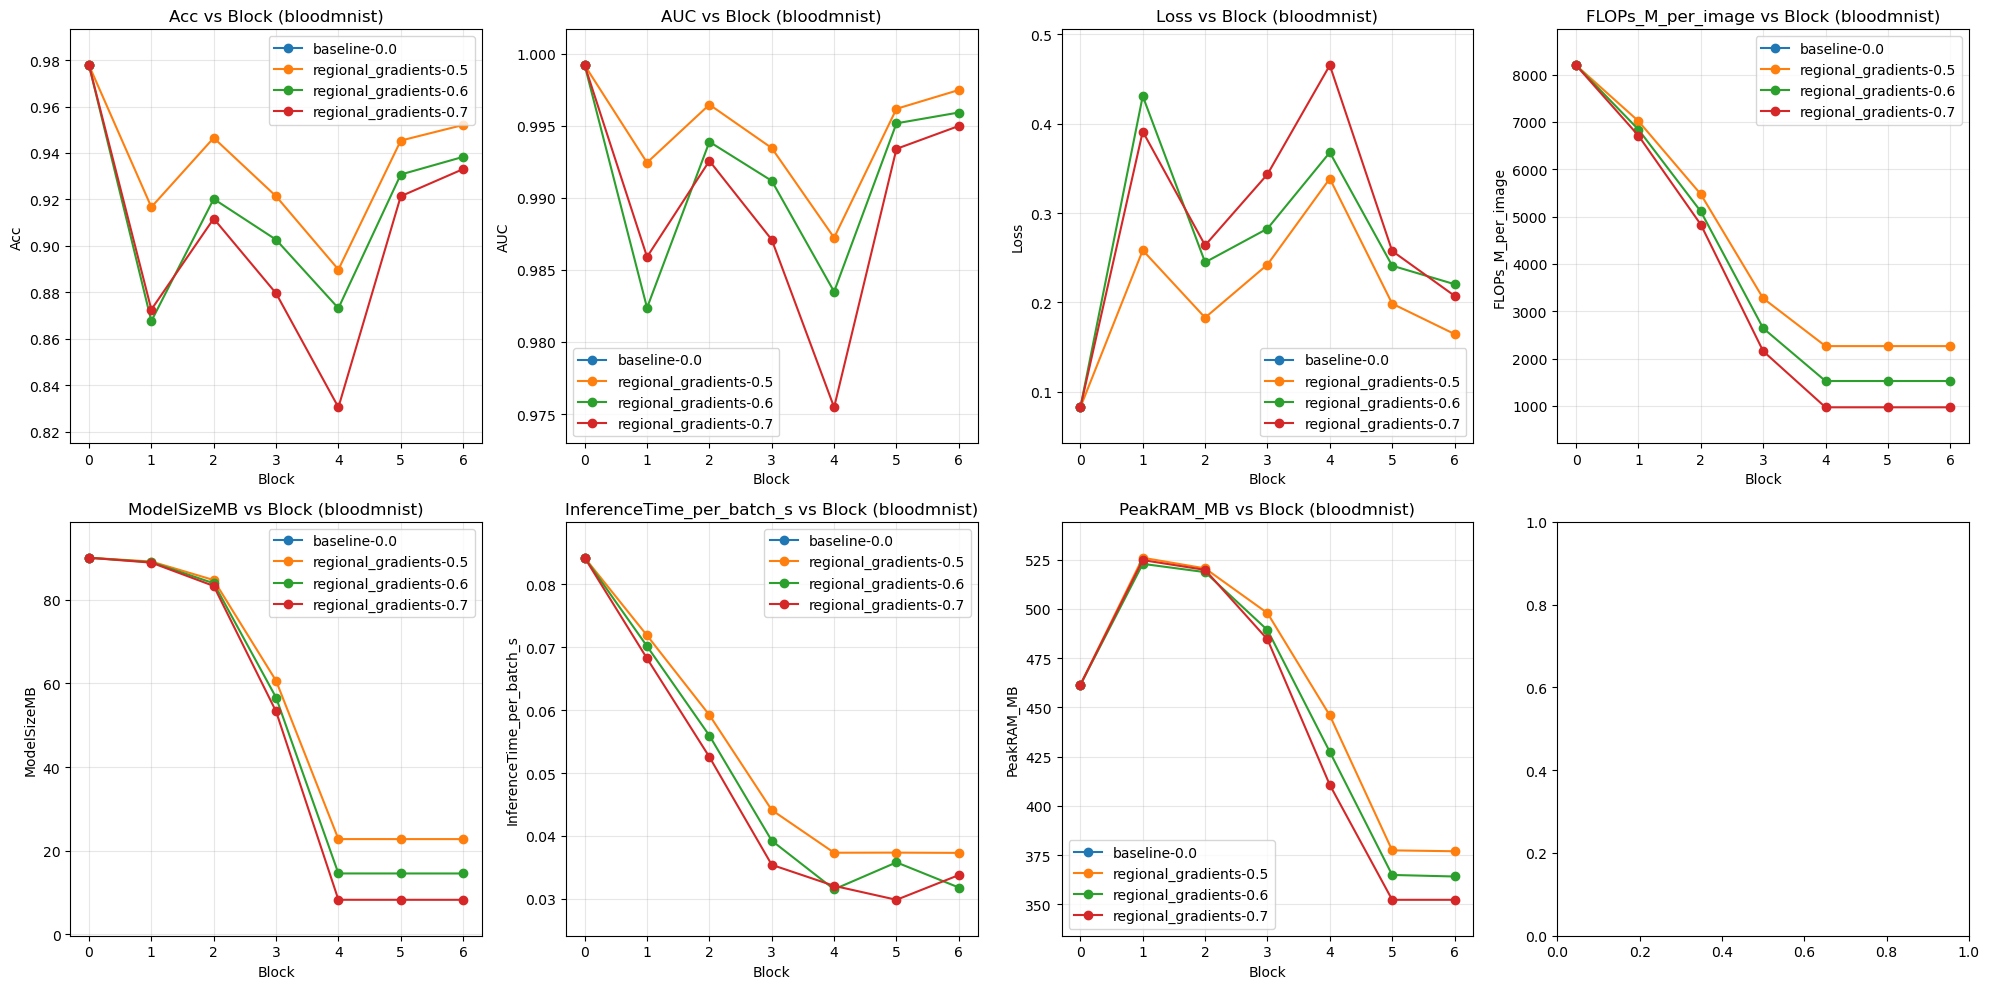

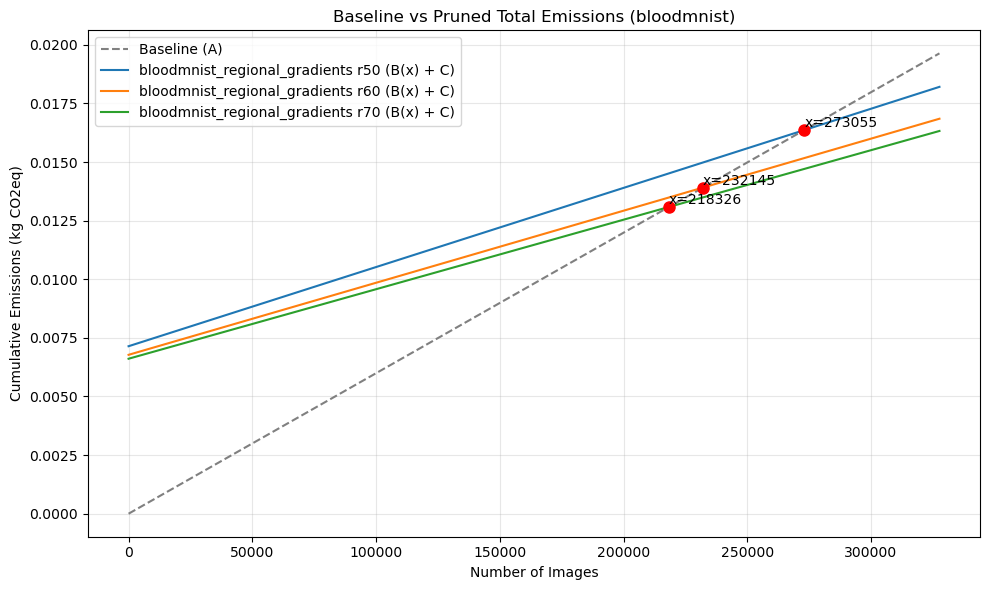

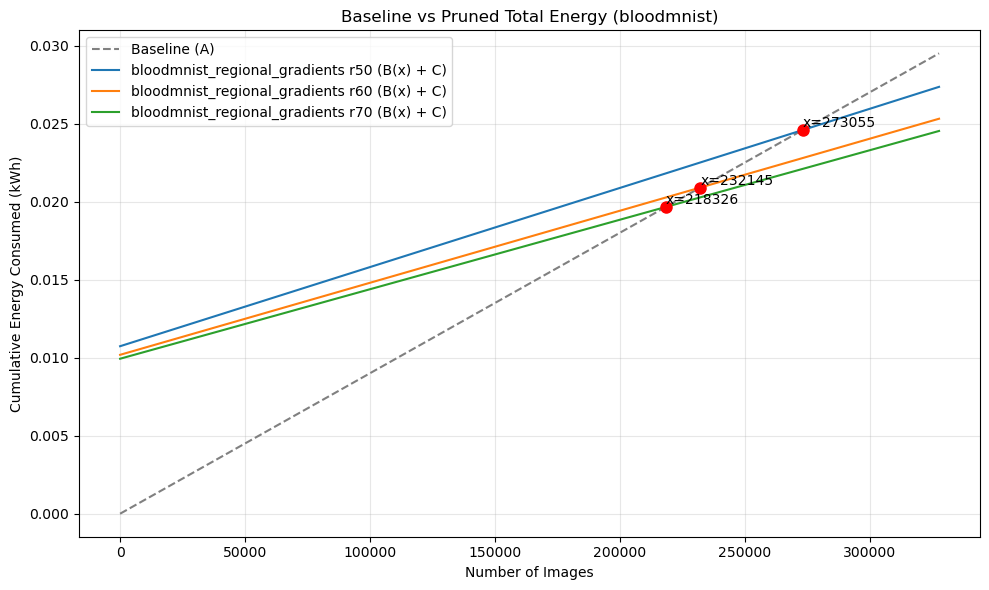

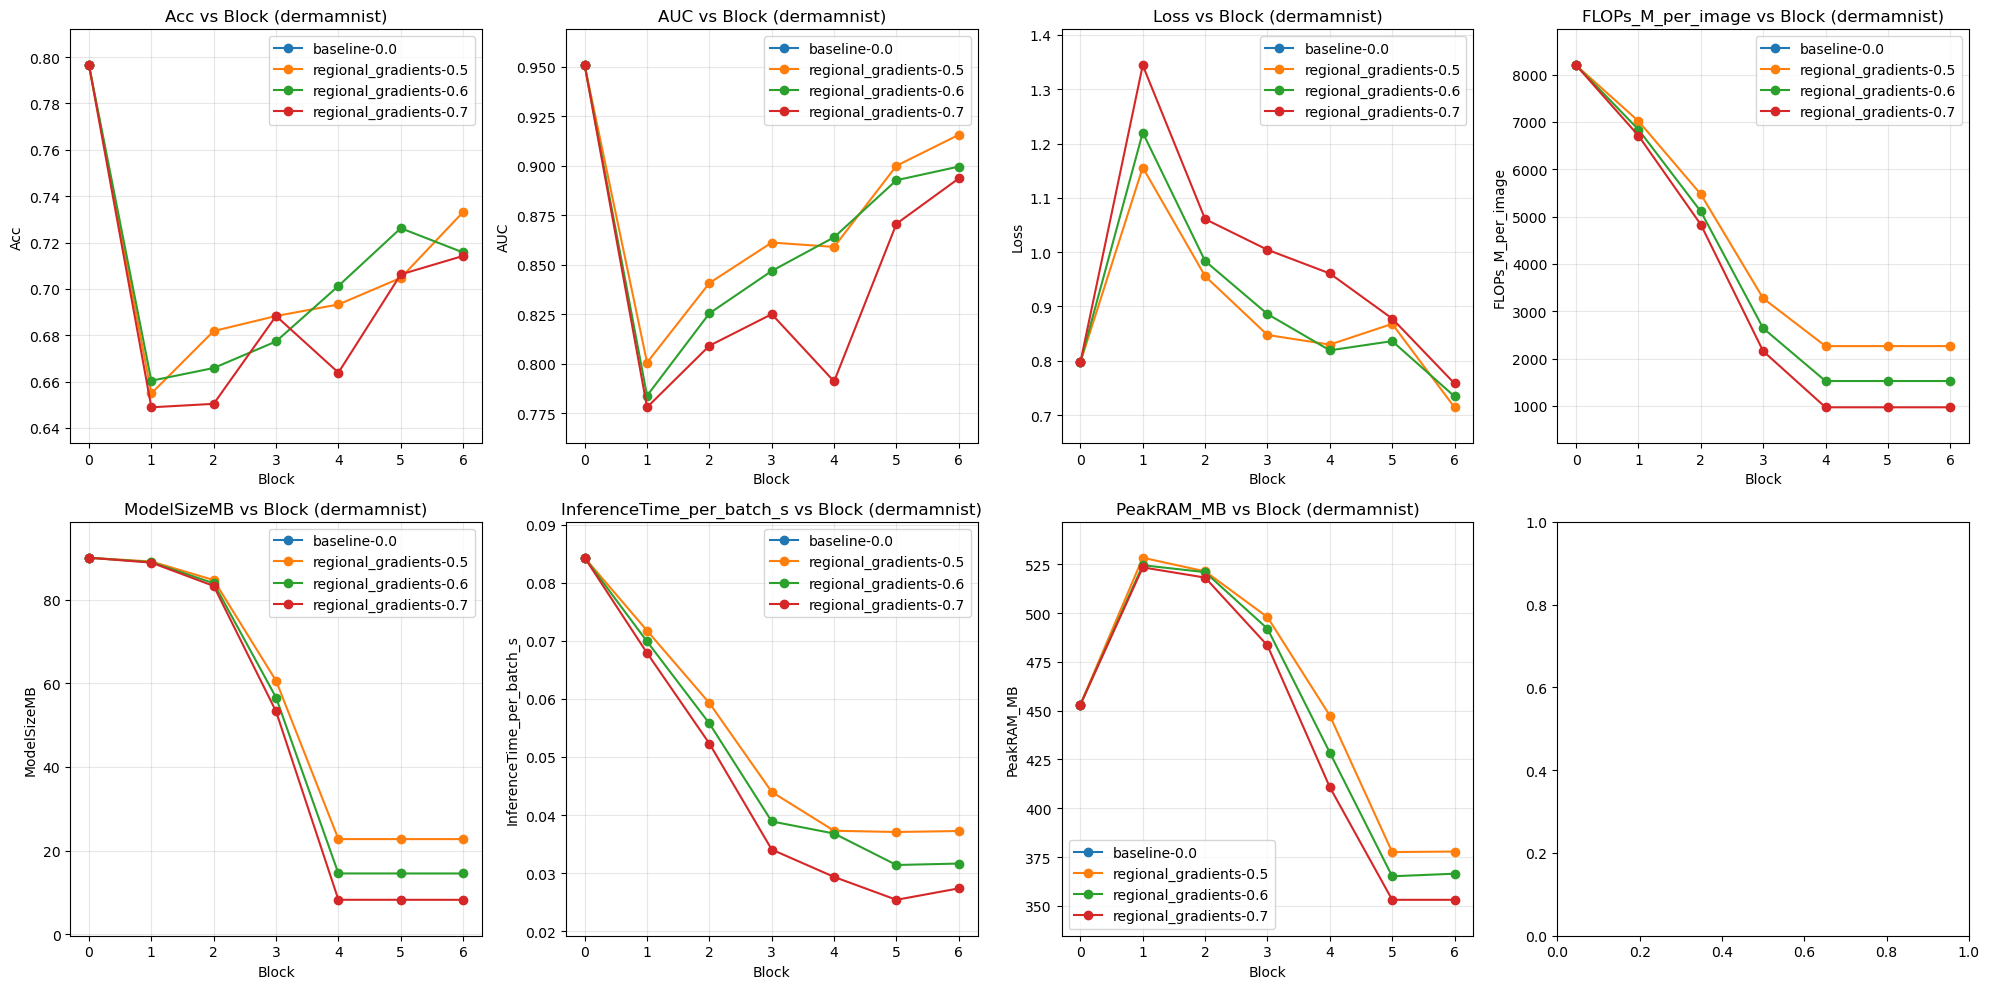

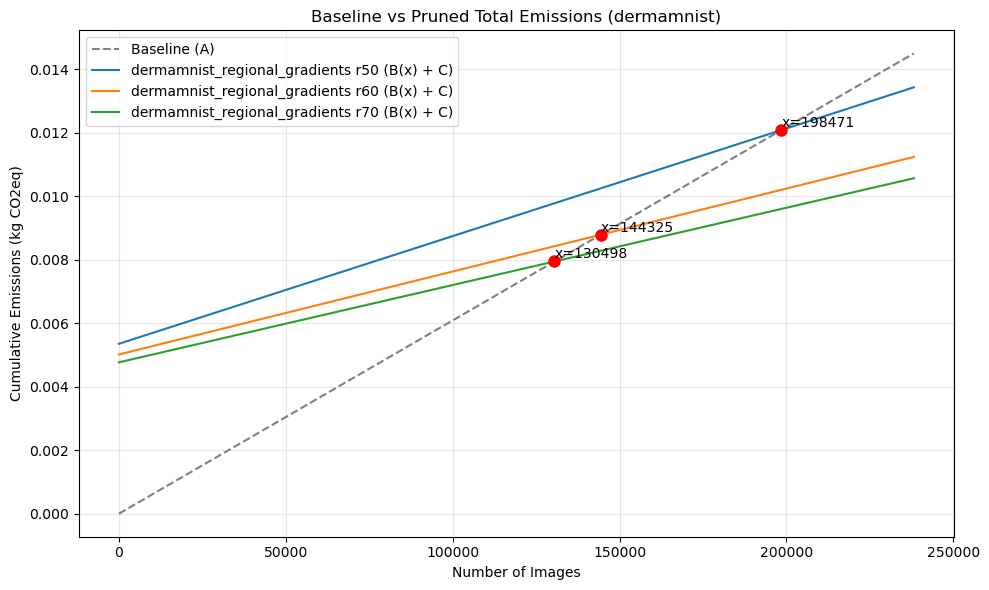

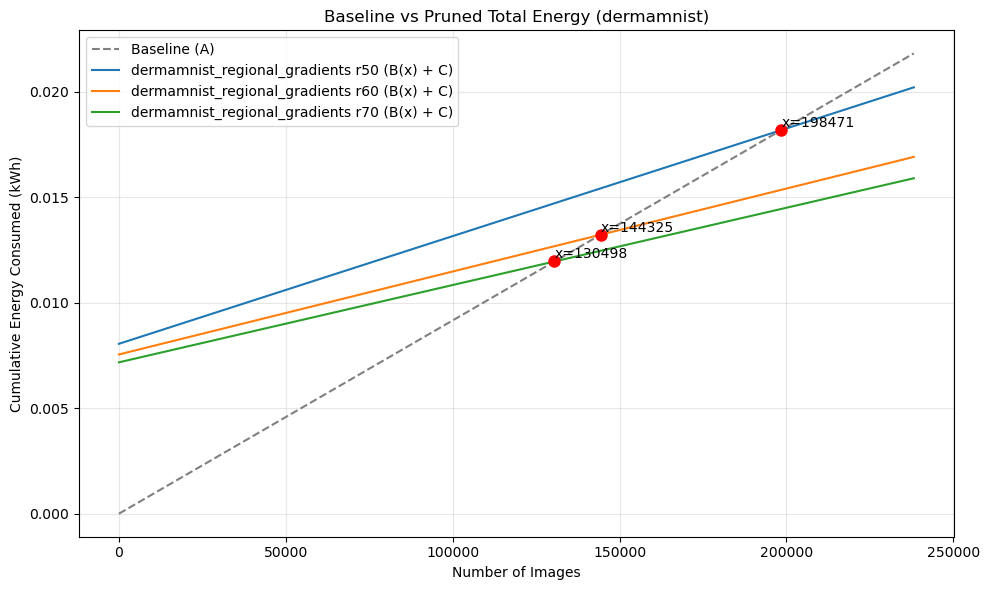

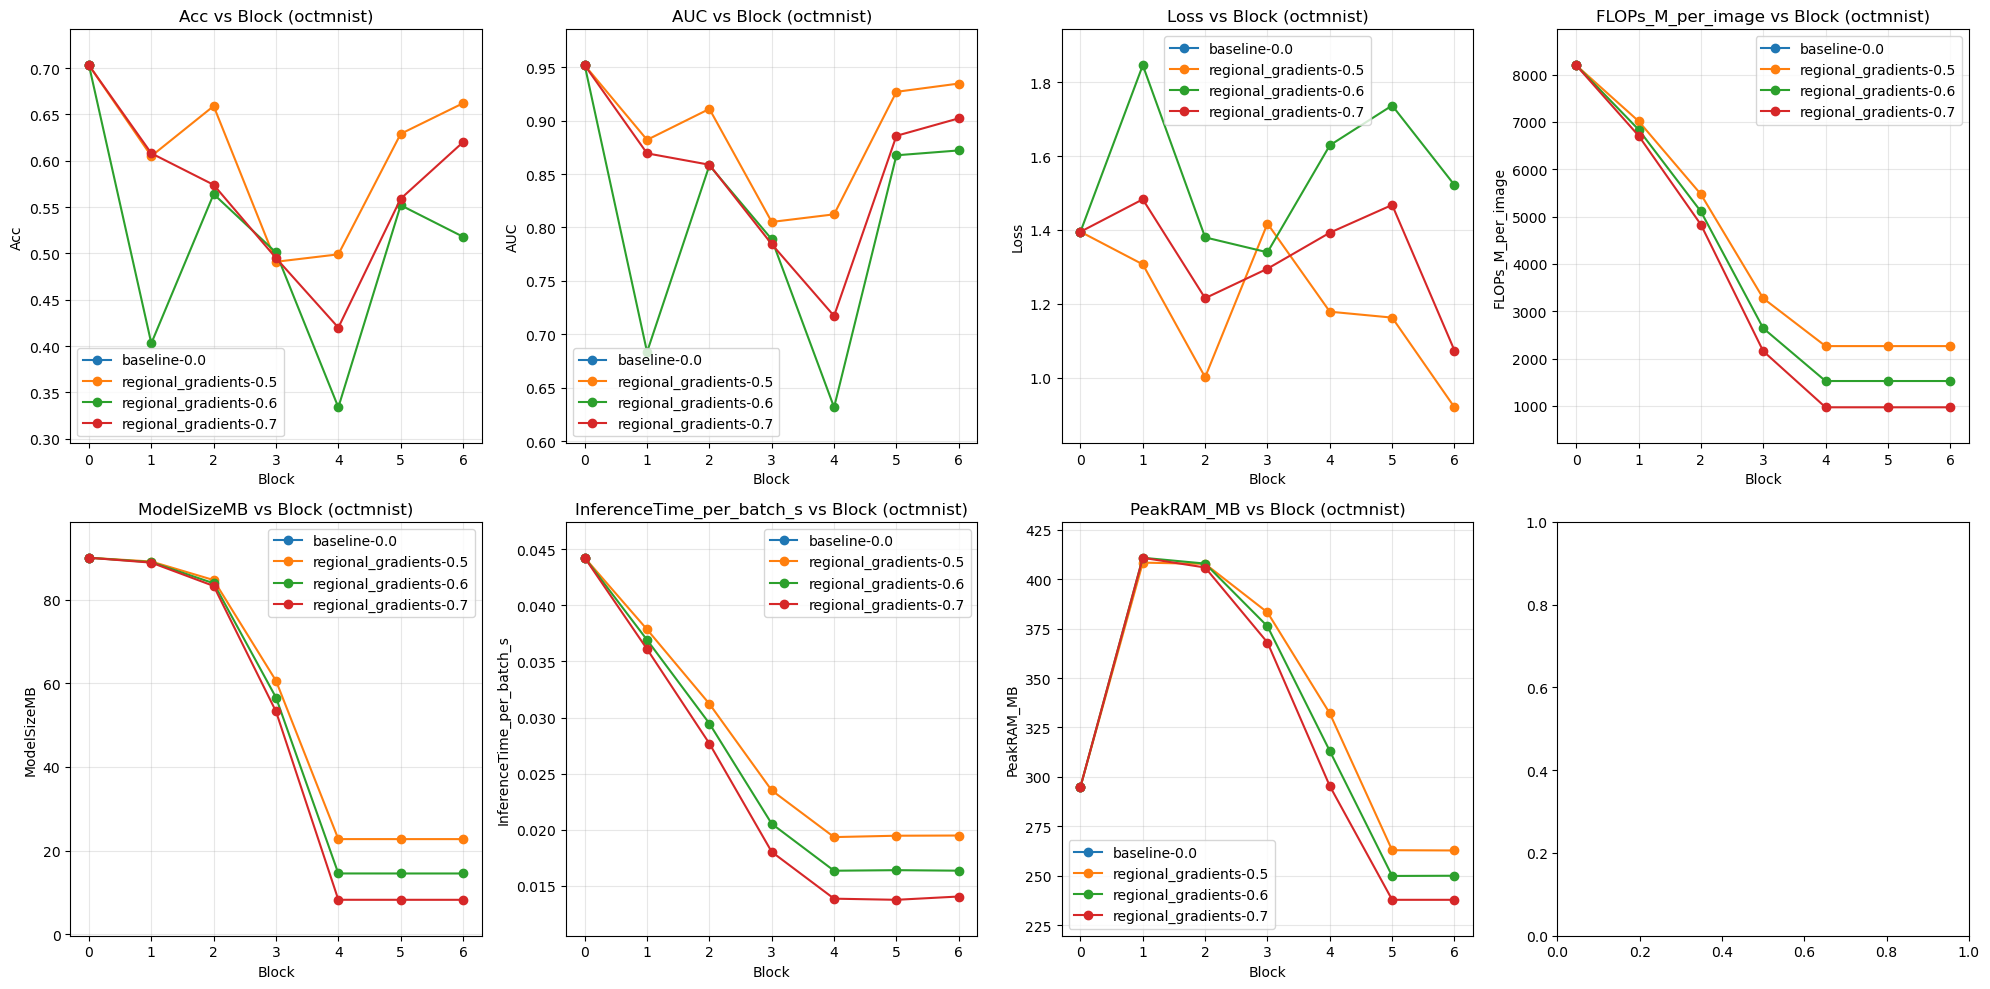

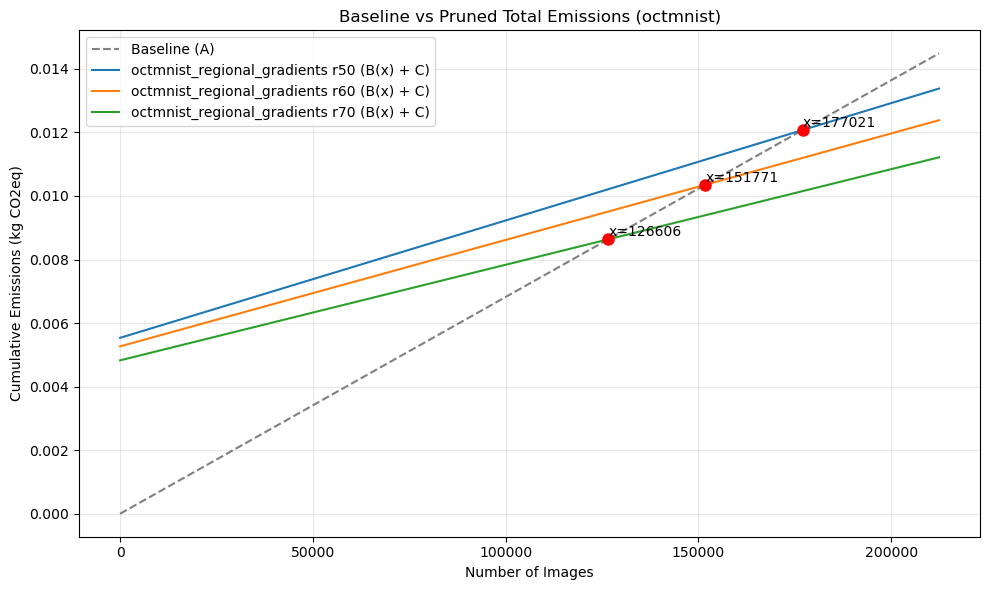

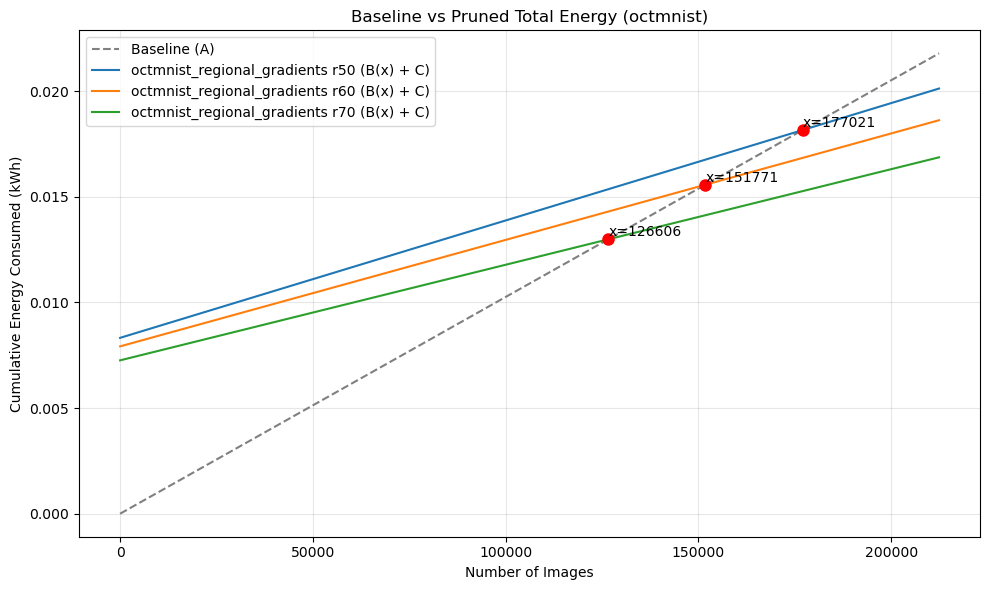

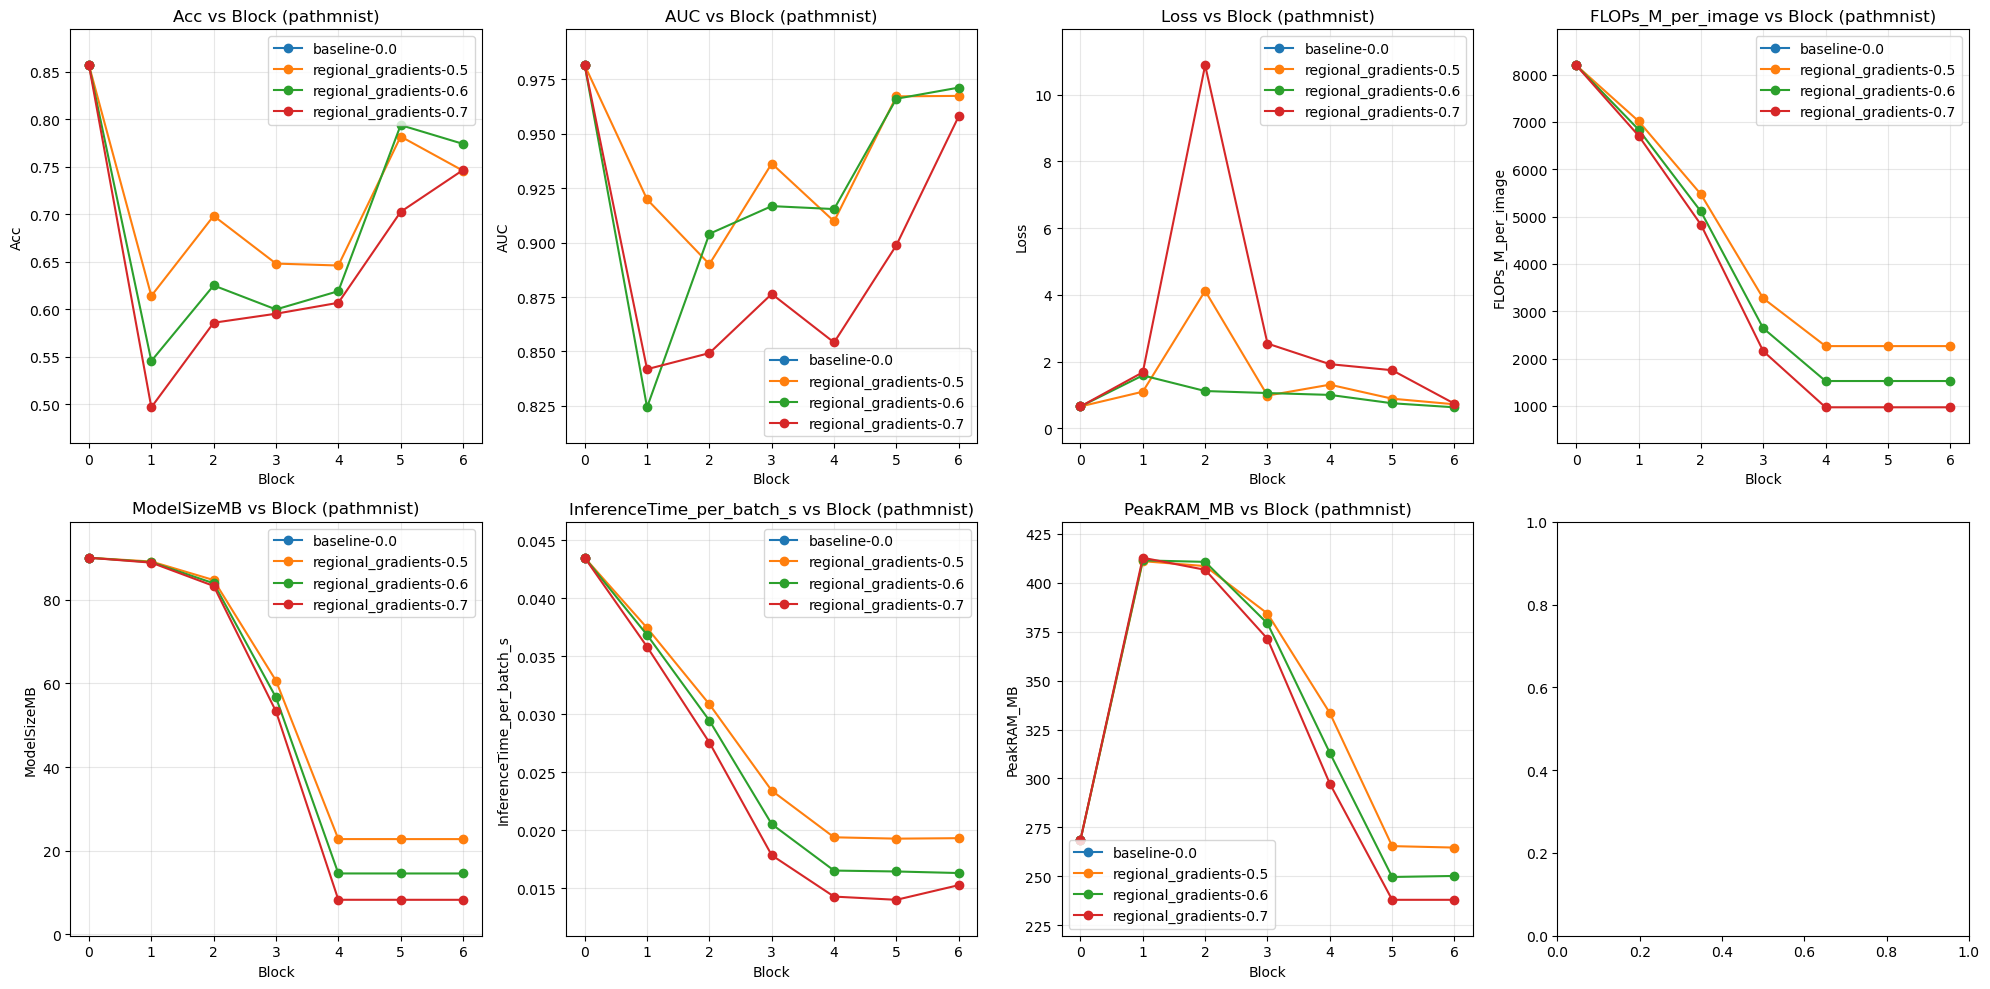

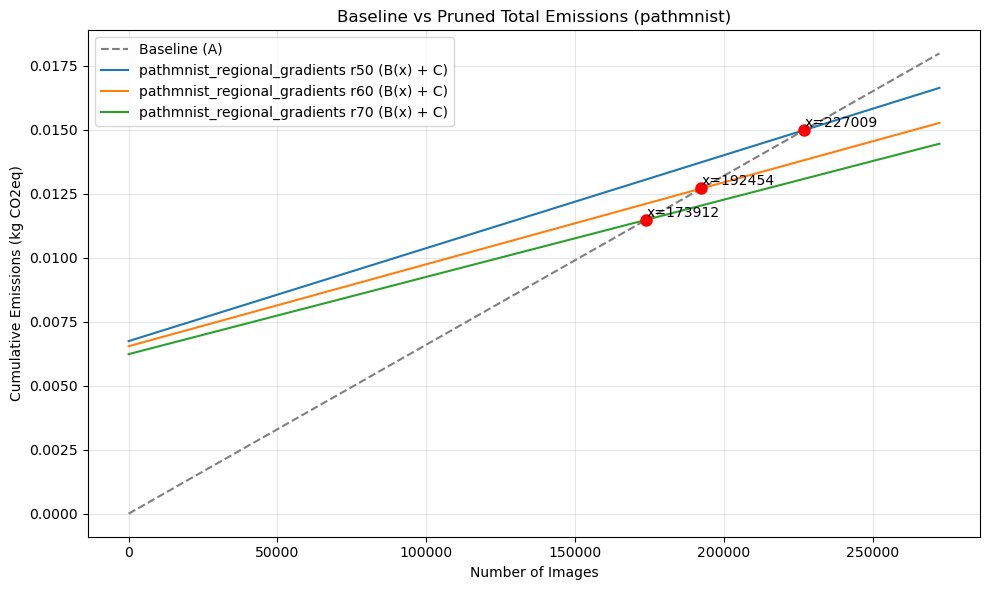

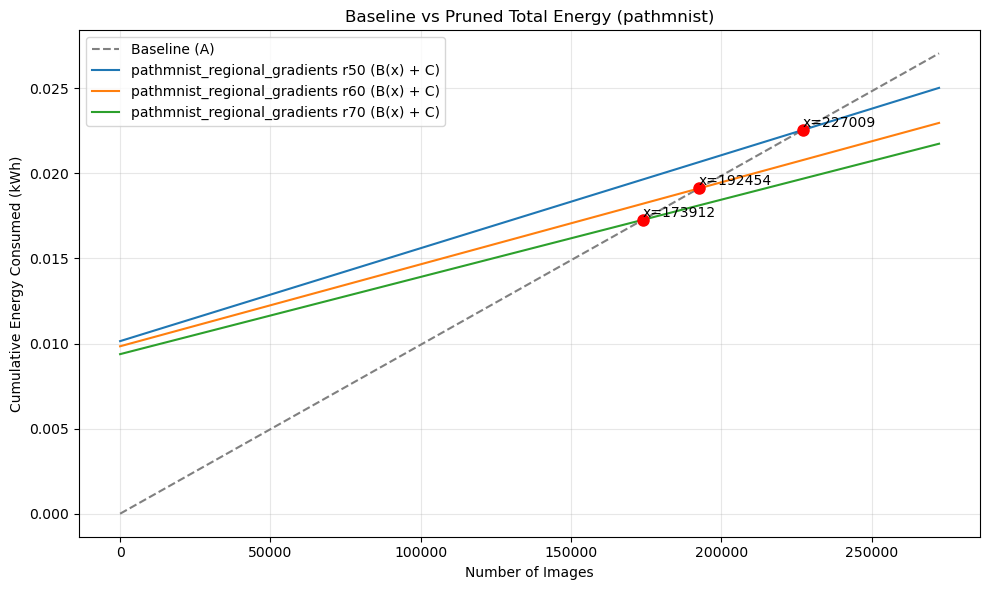

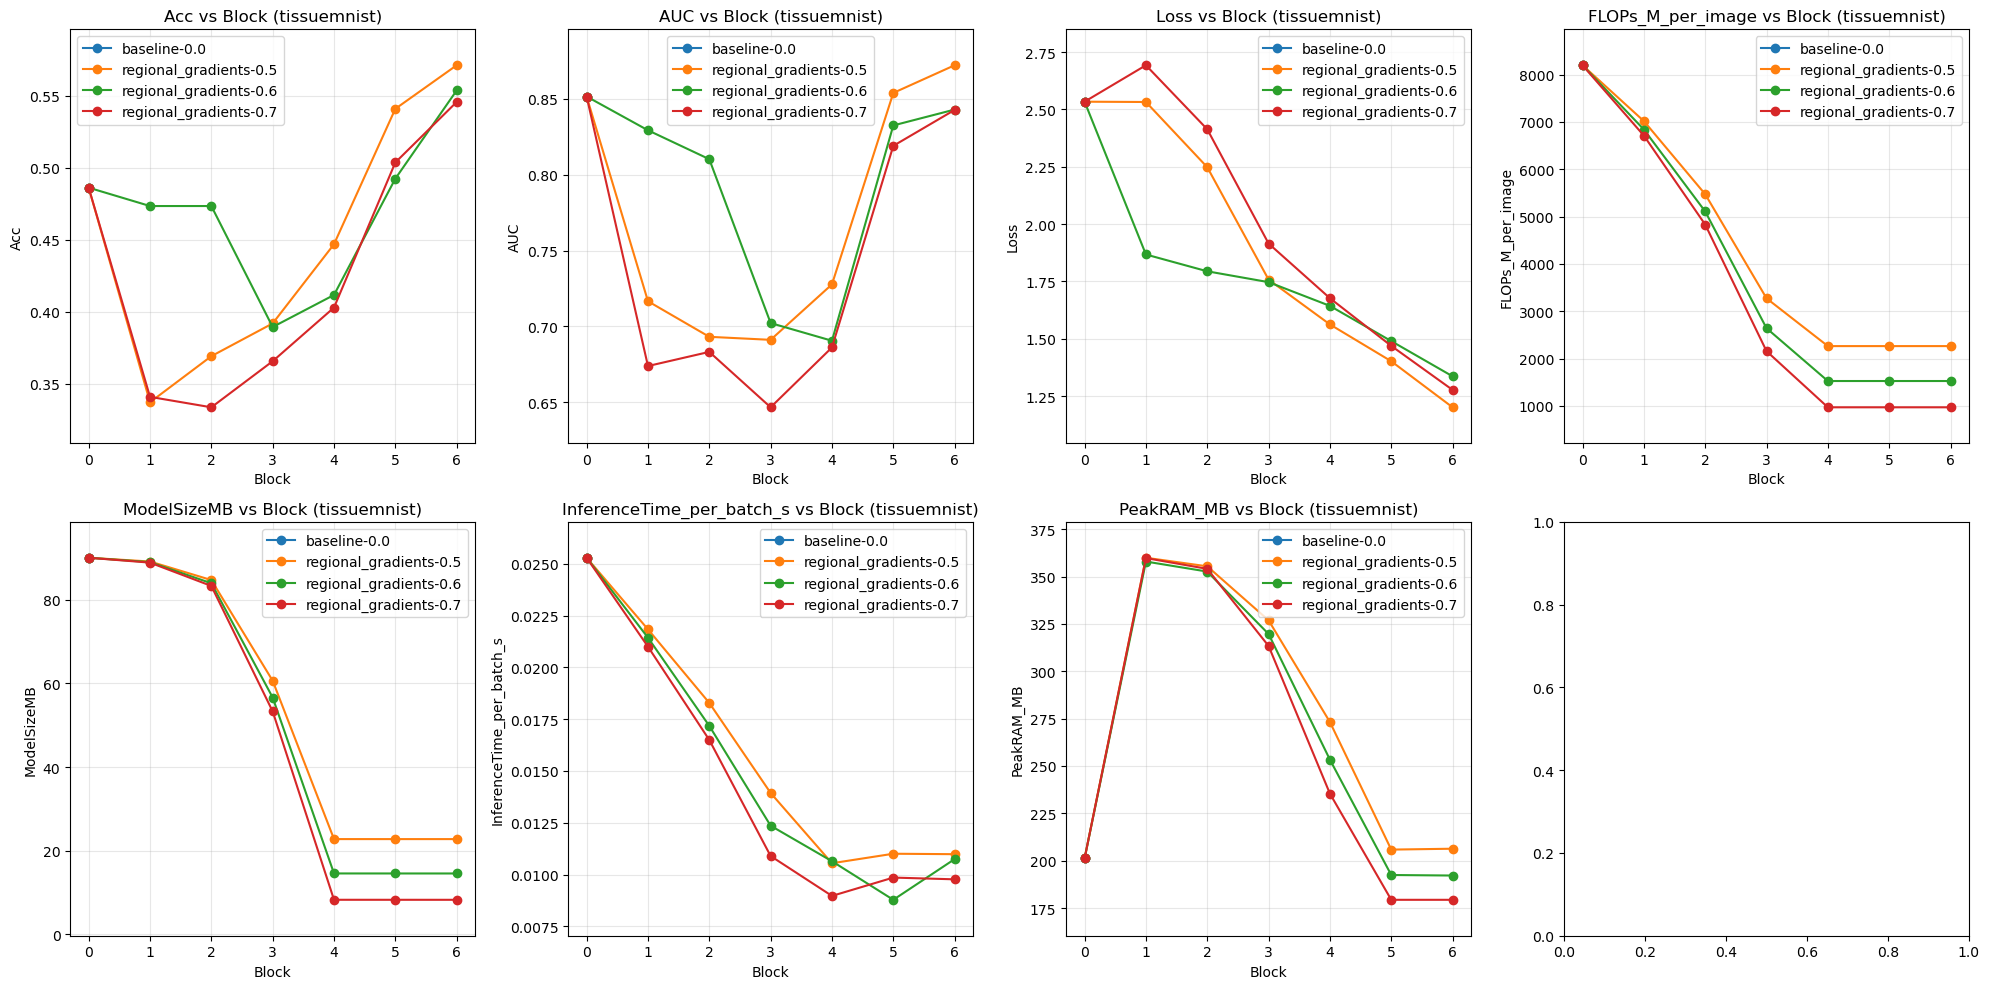

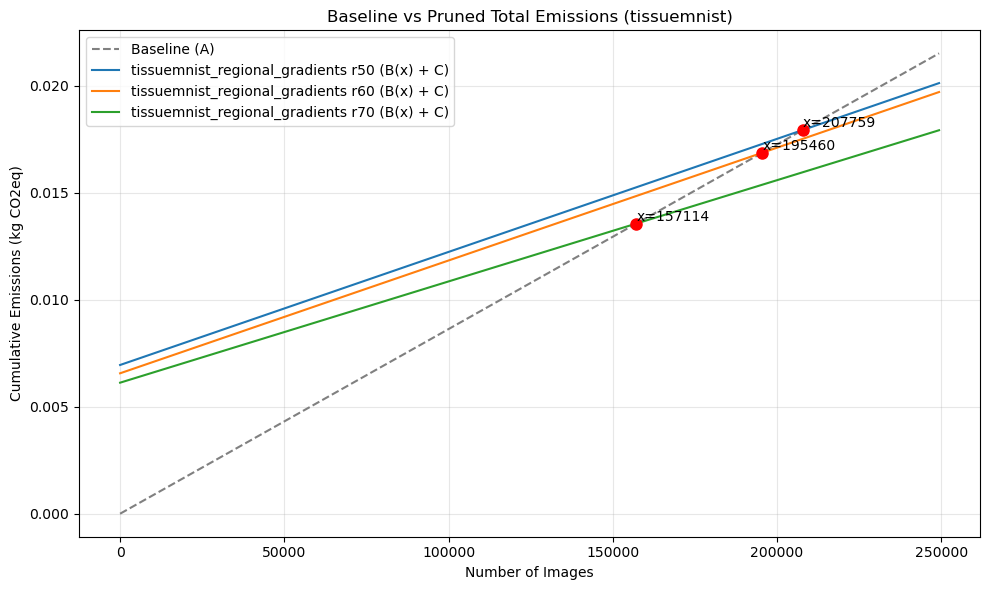

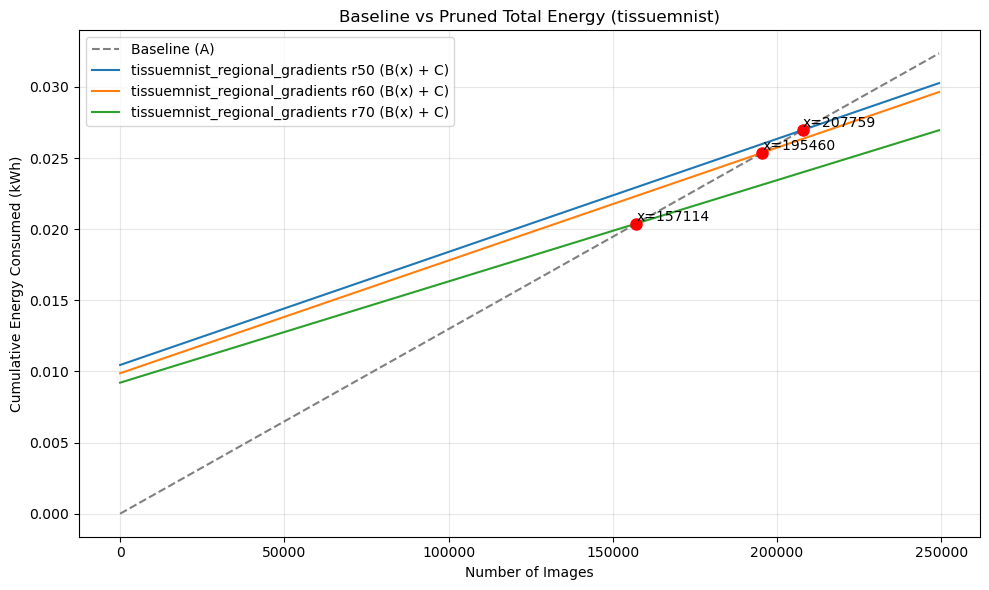

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

def visualize_pruning_metrics(root_path):
    subdirs = ['bloodmnist', 'dermamnist', 'octmnist', 'pathmnist', 'tissuemnist']
    
    # Dataset-specific image counts for inference (WARMUP=5 + TIMING_BATCHES=30) * batch_size
    INFERENCE_IMAGE_COUNTS = {
        'dermamnist': (5 + 30) * 32,   # 1120 images
        'pathmnist': (5 + 30) * 16,    # 560 images
        'bloodmnist': (5 + 30) * 32,   # 1120 images
        'octmnist': (5 + 30) * 16,     # 560 images
        'tissuemnist': (5 + 30) * 8    # 280 images
    }
    
    for subdir in subdirs:
        subdir_path = os.path.join(root_path, subdir)
        pruning_csv = os.path.join(subdir_path, f"{subdir}_pgto_pruning_metrics_progressive_fixed_with_energy.csv")
        emissions_csv = os.path.join(subdir_path, 'emissions.csv')
        
        if not os.path.exists(pruning_csv):
            print(f"Pruning CSV not found for {subdir}: {pruning_csv}")
            continue
        if not os.path.exists(emissions_csv):
            print(f"Emissions CSV not found for {subdir}: {emissions_csv}")
            continue
        
        # Load and process pruning metrics
        df = pd.read_csv(pruning_csv)
        
        # Keep only desired stages
        stages_keep = ["postcalib", "after_kd", "after_global_finetune", "baseline"]
        df = df[df["Stage"].apply(lambda s: any(k in s for k in stages_keep))].copy()
        
        # Map Stage -> Block index
        def stage_to_block(stage: str):
            if stage == "baseline":
                return 0
            elif "layer1" in stage and "postcalib" in stage:
                return 1
            elif "layer2" in stage and "postcalib" in stage:
                return 2
            elif "layer3" in stage and "postcalib" in stage:
                return 3
            elif "layer4" in stage and "postcalib" in stage:
                return 4
            elif stage == "after_kd":
                return 5
            elif stage == "after_global_finetune":
                return 6
            return None
        
        df["Block"] = df["Stage"].apply(stage_to_block)
        
        # Use all unique (Variant, Ratio) pairs
        variants = df[["Variant", "Ratio"]].drop_duplicates().values.tolist()
        
        # Metrics to plot
        metrics = [
            "Acc", "AUC", "Loss",
            "FLOPs_M_per_image", "ModelSizeMB",
            "InferenceTime_per_batch_s", "PeakRAM_MB"
        ]
        
        # Create a subplot for all metrics for this dataset
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        axs = axs.ravel()
        
        for idx, metric in enumerate(metrics):
            ax = axs[idx]
            
            for method, ratio in variants:
                # Get subset
                subset = df[(df["Variant"] == method) & (df["Ratio"] == ratio)].copy()
                
                # Add baseline explicitly for this variant/ratio
                baseline = df[df["Stage"] == "baseline"].copy()
                baseline["Variant"] = method
                baseline["Ratio"] = ratio
                subset = pd.concat([baseline, subset])
                
                # Order by Block
                subset = subset.sort_values("Block")
                
                # Plot
                ax.plot(
                    subset["Block"], subset[metric],
                    marker="o", label=f"{method}-{ratio}"
                )
            
            ax.set_xlabel("Block")
            ax.set_ylabel(metric)
            ax.set_title(f"{metric} vs Block ({subdir})")
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # X-axis ticks
            unique_blocks = sorted(df["Block"].dropna().unique())
            ax.set_xticks(unique_blocks)
            
            # Add y padding
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))
        
        plt.tight_layout()
        plt.show()
        
        # Emissions/energy handling
        df_em = pd.read_csv(emissions_csv)
        
        # Parse project_name to extract variant, ratio, and type
        def parse_project_name(name):
            if 'baseline_inference' in name:
                return 'baseline', 0, 'inference'
            match = re.search(r'(.+)_r(\d+)_prune_retrain', name)
            if match:
                variant, ratio_str = match.groups()
                return variant, int(ratio_str), 'prune_retrain'
            match = re.search(r'(.+)_r(\d+)_pruned_inference', name)
            if match:
                variant, ratio_str = match.groups()
                return variant, int(ratio_str), 'pruned_inference'
            return None, None, None
        
        df_em[['Variant', 'Ratio', 'Type']] = df_em['project_name'].apply(
            lambda x: pd.Series(parse_project_name(x))
        )
        
        # Filter valid parses
        df_em_valid = df_em.dropna(subset=['Variant', 'Ratio', 'Type'])
        
        # Get baseline per-image cost
        num_images = INFERENCE_IMAGE_COUNTS.get(subdir, 1000)  # Fallback to 1000
        baseline_rows = df_em_valid[(df_em_valid['Variant'] == 'baseline') & (df_em_valid['Type'] == 'inference')]
        baseline_emissions_per_image = baseline_rows['emissions'].sum() / num_images if len(baseline_rows) > 0 else np.nan
        baseline_energy_per_image = baseline_rows['energy_consumed'].sum() / num_images if len(baseline_rows) > 0 else np.nan
        
        # Group by Variant, Ratio, Type and sum
        agg_df = df_em_valid.groupby(['Variant', 'Ratio', 'Type'])[['emissions', 'energy_consumed']].sum().reset_index()
        
        # Pivot to get prune_retrain (C) and pruned_inference (B)
        pruned_df = agg_df[agg_df['Type'] == 'pruned_inference'].rename(
            columns={'emissions': 'B_emissions', 'energy_consumed': 'B_energy'}
        )
        retrain_df = agg_df[agg_df['Type'] == 'prune_retrain'].rename(
            columns={'emissions': 'C_emissions', 'energy_consumed': 'C_energy'}
        )
        
        # Merge on Variant and Ratio
        merged = pd.merge(
            pruned_df[['Variant', 'Ratio', 'B_emissions', 'B_energy']],
            retrain_df[['Variant', 'Ratio', 'C_emissions', 'C_energy']],
            on=['Variant', 'Ratio'], how='inner'
        )
        
        # Compute per-image inference costs for pruned models
        merged['B_emissions_per_image'] = merged['B_emissions'] / num_images
        merged['B_energy_per_image'] = merged['B_energy'] / num_images
        
        # Compute intersection points to set x-axis scale
        valid_intersections_em = []
        valid_intersections_en = []
        for _, row in merged.iterrows():
            B_em_per_image = row['B_emissions_per_image']
            C_em = row['C_emissions']
            B_en_per_image = row['B_energy_per_image']
            C_en = row['C_energy']
            
            # Emissions intersection
            if not np.isnan(baseline_emissions_per_image) and baseline_emissions_per_image > B_em_per_image:
                delta_em = baseline_emissions_per_image - B_em_per_image
                break_even_x_em = C_em / delta_em
                if break_even_x_em > 0:
                    valid_intersections_em.append(break_even_x_em)
            
            # Energy intersection
            if not np.isnan(baseline_energy_per_image) and baseline_energy_per_image > B_en_per_image:
                delta_en = baseline_energy_per_image - B_en_per_image
                break_even_x_en = C_en / delta_en
                if break_even_x_en > 0:
                    valid_intersections_en.append(break_even_x_en)
        
        # Set max_images based on intersections
        DEFAULT_MAX_IMAGES = 100000
        MAX_IMAGES_CAP = 1000000
        max_images_em = max(valid_intersections_em) * 1.2 if valid_intersections_em else DEFAULT_MAX_IMAGES
        max_images_en = max(valid_intersections_en) * 1.2 if valid_intersections_en else DEFAULT_MAX_IMAGES
        max_images_em = min(max(max_images_em, 10000), MAX_IMAGES_CAP)
        max_images_en = min(max(max_images_en, 10000), MAX_IMAGES_CAP)
        
        unique_variants = merged['Variant'].unique()
        
        # Plot for emissions
        if not merged.empty and not np.isnan(baseline_emissions_per_image):
            plt.figure(figsize=(10, 6))
            
            # Baseline line: A(x)
            x_values = np.linspace(0, max_images_em, 100)
            plt.plot(x_values, baseline_emissions_per_image * x_values, 
                     linestyle='--', color='gray', label='Baseline (A)')
            
            # Pruned totals: B(x) + C
            for variant in unique_variants:
                subset = merged[merged['Variant'] == variant].sort_values('Ratio')
                for _, row in subset.iterrows():
                    ratio = row['Ratio']
                    B_per_image = row['B_emissions_per_image']
                    C = row['C_emissions']
                    plt.plot(x_values, (B_per_image * x_values) + C, 
                             marker=None, label=f"{variant} r{ratio} (B(x) + C)")
                    
                    # Plot intersection
                    if baseline_emissions_per_image > B_per_image:
                        break_even_x = C / (baseline_emissions_per_image - B_per_image)
                        if 0 < break_even_x < max_images_em:
                            break_even_y = baseline_emissions_per_image * break_even_x
                            plt.plot(break_even_x, break_even_y, 'ro', markersize=8)
                            plt.text(break_even_x, break_even_y, f'x={int(break_even_x)}', 
                                     verticalalignment='bottom', horizontalalignment='left', fontsize=10)
            
            plt.xlabel("Number of Images")
            plt.ylabel("Cumulative Emissions (kg CO2eq)")
            plt.title(f"Baseline vs Pruned Total Emissions ({subdir})")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid emissions data for {subdir}")
        
        # Plot for energy_consumed
        if not merged.empty and not np.isnan(baseline_energy_per_image):
            plt.figure(figsize=(10, 6))
            
            # Baseline line: A(x)
            x_values = np.linspace(0, max_images_en, 100)
            plt.plot(x_values, baseline_energy_per_image * x_values, 
                     linestyle='--', color='gray', label='Baseline (A)')
            
            # Pruned totals: B(x) + C
            for variant in unique_variants:
                subset = merged[merged['Variant'] == variant].sort_values('Ratio')
                for _, row in subset.iterrows():
                    ratio = row['Ratio']
                    B_per_image = row['B_energy_per_image']
                    C = row['C_energy']
                    plt.plot(x_values, (B_per_image * x_values) + C, 
                             marker=None, label=f"{variant} r{ratio} (B(x) + C)")
                    
                    # Plot intersection
                    if baseline_energy_per_image > B_per_image:
                        break_even_x = C / (baseline_energy_per_image - B_per_image)
                        if 0 < break_even_x < max_images_en:
                            break_even_y = baseline_energy_per_image * break_even_x
                            plt.plot(break_even_x, break_even_y, 'ro', markersize=8)
                            plt.text(break_even_x, break_even_y, f'x={int(break_even_x)}', 
                                     verticalalignment='bottom', horizontalalignment='left', fontsize=10)
            
            plt.xlabel("Number of Images")
            plt.ylabel("Cumulative Energy Consumed (kWh)")
            plt.title(f"Baseline vs Pruned Total Energy ({subdir})")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid energy data for {subdir}")

visualize_pruning_metrics("/Users/arihangupta/Downloads/pruning_project_data")